# History of decentralized irrigation

This notebook has the goal of answering the question: from 2000 to 2015, does the Mehta and Meier data show irrigation expansion moving away from dams? 

For each irrigation pixel in every year I can get, I need: 
- the irrigation percent
- the distance to the nearest dam (ideally nearest upstream dam)
- the country it's in, for controls

Regression: 
- Does the year explain the distance to the nearest dam (with irrigation percent weights)

Inventory of data: 
- Irrigation data
    - Both Mehta and Meier data downloadable at https://zenodo.org/records/7809342 
    - Africa_AEI_2015_asc_path: 'Data/Raw/G_AEI_2015.ASC' # From https://zenodo.org/records/7809342
- Dam data: 
    - Global_Dam_Data_csv_path: 'Data/Raw/globaldamsdatabase_global_coverage_november_2020.csv' # from https://sedac.ciesin.columbia.edu/data/set/grand-v1-dams-rev01/maps?facets=region:africa
    - Global_Dam_Data_shp_path: 'Data/Raw/GDAT_data_v1/data/GDAT_v1_dams.shp' # Retrieved from https://zenodo.org/records/7616852 7/29/24 (alternative dataset)
- Country boundaries:
    - Africa_Countries_shp_path: 'Data/Raw/Africa_Countries-shp' # from https://open.africa/dataset/africa-shapefiles
- Elevation: 
    - Africa_Elevation_rast_path: 'Data/Raw/africa_dem' # from https://databasin.org/datasets/2965da954b114ff3b47621e99e3b29ba/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point
import geopandas as gpd
# import seaborn as sns
import rasterio

data_loc = '/home/waves/data/Africa_Irrigation/Data'
raw_data_dir = os.path.join(data_loc, 'anna', 'raw')
years = range(1980, 2016, 5)

# Dam data

Index(['GRAND_ID', 'RES_NAME', 'DAM_NAME', 'ALT_NAME', 'RIVER', 'ALT_RIVER',
       'MAIN_BASIN', 'SUB_BASIN', 'NEAR_CITY', 'ALT_CITY', 'ADMIN_UNIT',
       'SEC_ADMIN', 'COUNTRY', 'SEC_CNTRY', 'YEAR', 'ALT_YEAR', 'DAM_HGT_M',
       'ALT_HGT_M', 'DAM_LEN_M', 'ALT_LEN_M', 'AREA_SKM', 'AREA_POLY',
       'AREA_REP', 'AREA_MAX', 'AREA_MIN', 'CAP_MCM', 'CAP_MAX', 'CAP_REP',
       'CAP_MIN', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM',
       'CATCH_REP', 'DATA_INFO', 'USE_IRRI', 'USE_ELEC', 'USE_SUPP',
       'USE_FCON', 'USE_RECR', 'USE_NAVI', 'USE_FISH', 'USE_PCON', 'USE_LIVE',
       'USE_OTHR', 'MAIN_USE', 'LAKE_CTRL', 'MULTI_DAMS', 'TIMELINE',
       'COMMENTS', 'URL', 'QUALITY', 'EDITOR', 'LONG_DD', 'LAT_DD',
       'geometry'],
      dtype='object')


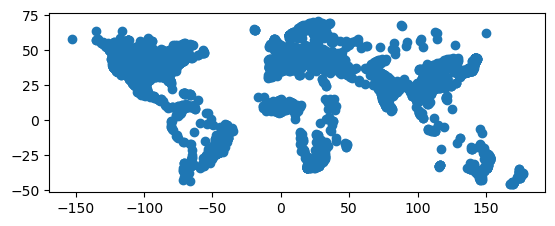

In [5]:
# Load the dam data
dam_data_path = os.path.join(raw_data_dir, 'dams-rev01-global-shp', 'GRanD_dams_v1_1.shp')
dam_data = gpd.read_file(dam_data_path)

# if the year is less than 0, this needs to be converted to nan
dam_data['YEAR'] = dam_data['YEAR'].replace(-99, np.nan)

## Irrigation data

# Targetting ratios

What I need to do now is:
- Calculate the distance of each irrigated pixel for both the Meier data and the Mehta data to the nearest dam for every year we have
- Calculate the fraction of irrigation that is 1-10, 10-20, 20-30, 30-40, 40-50, 50-75, and 75+ km from the nearest dam by country (and globally and for SSA) with confidence intervals
- Plot these fractions (y axis) against distance (x axis) with the year as the color for:
    - The whole world
    - Sub-Sahararn Africa

   iso3                 status color_code                      name continent  \
0   MNP           US Territory        USA  Northern Mariana Islands   Oceania   
1  None  Sovereignty unsettled        RUS             Kuril Islands      Asia   
2   FRA           Member State        FRA                    France    Europe   
3   SRB           Member State        SRB                    Serbia    Europe   
4   URY           Member State        URY                   Uruguay  Americas   

            region iso_3166_1_               french_shor  \
0       Micronesia          MP  Northern Mariana Islands   
1     Eastern Asia        None             Kuril Islands   
2   Western Europe          FR                    France   
3  Southern Europe          RS                    Serbie   
4    South America          UY                   Uruguay   

                                            geometry  
0  MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...  
1  MULTIPOLYGON (((146.68274 43.70777, 146

<Axes: >

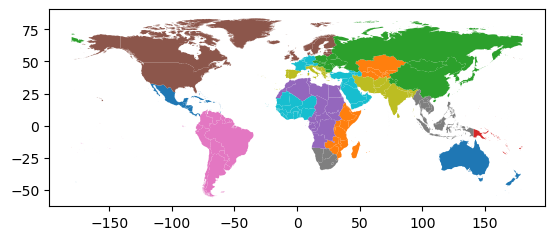

In [11]:
# Load the country boundaries
world_boundaries_path = os.path.join(raw_data_dir, 'world_boundaries', 'world-administrative-boundaries.shp')
world_boundaries = gpd.read_file(world_boundaries_path)

# Plot the country boundaries with the color by region
print(world_boundaries.head())
world_boundaries.plot(column='region')

In [5]:
# Turn the Mehta data into a geopandas dataframe with the following columns: 
    # - Pixel ID
    # - Latitude
    # - Longitude
    # - Year
    # - Irrigation area
    # - Country (from the country boundaries data)
    # - Geometry
# We only want to keep pixels that are within the boundary of a country

years = range(1980, 2016, 5)
raw_data_dir = os.path.join(data_loc, 'anna', 'raw')
aei_dir = os.path.join(raw_data_dir, 'AEI')

# Create an empty list to store the data
data = []

# Loop through each year and extract the pixel information
for i, year in enumerate(years):
    # Get the raster for the current year
        file_path = os.path.join(aei_dir, f"G_AEI_{year}.ASC")
        with rasterio.open(file_path) as src:
            image = src.read(1)

            # Get the affine transformation of the raster (maps pixel coordinates to spatial coordinates)
            transform = src.transform

            # List to store the points and corresponding values
            points = []
            values = []

            # Iterate over the raster and create points for each pixel
            for row in range(image.shape[0]):
                for col in range(image.shape[1]):
                    # Get the value of the pixel
                    value = image[row, col]

                    # Skip nodata values (optional, depending on your use case)
                    if value != src.nodata:
                        # Get the coordinates of the pixel in spatial units
                        x, y = rasterio.transform.xy(transform, row, col)

                        # Create a point and store it
                        points.append(Point(x, y))
                        values.append(value)

        # Create a GeoDataFrame from the points
        gdf = gpd.GeoDataFrame({'AEI': values, 'Year': year, 'geometry': points})

        # Add the data to the list
        data.append(gdf)

# Concatenate the dataframes into a single GeoDataFrame
mehta_df = pd.concat(data)

# Reset the index
mehta_df.reset_index(drop=True, inplace=True)

# Rename the columns
# mehta_df.rename(columns={'id': 'Pixel ID', 'latitude': 'Latitude', 'longitude': 'Longitude', 'irrigation_area': 'Irrigation Area', 'country': 'Country', 'geometry': 'Geometry'}, inplace=True)

# Print the resulting dataframe
print(mehta_df.head())
